In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch 
from torchvision import transforms,datasets
import matplotlib.pyplot as plt 
from torch import nn
import numpy as np
import torchvision

In [2]:
train_dir='C:/Users/Administrator/Desktop/pytorchs/data/anime/'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)  # 标准化
])

train_ds = torchvision.datasets.ImageFolder(
    train_dir,
    transform=transform
)

train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True
)

In [3]:
# 定义生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,64*64*1),
            nn.Tanh()
        )
    
    def forward(self,x):
        img = self.main(x)
        img = img.view(-1,64,64,1)
        return img

In [4]:
# 定义判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(64*64*1,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = x.view(-1,64*64*1)
        x = self.main(x)
        return x

In [5]:
gen = Generator()       # 实例化生成器
dis = Discriminator()   # 实例化判别器
loss_fn = nn.BCELoss()   # 定义损失函数
g_optimizer = torch.optim.Adam(gen.parameters(),lr=0.0001)  # 生成器优化器
d_optimizer = torch.optim.Adam(dis.parameters(),lr=0.0001)  # 判别器优化器
test_seed = torch.randn(16,100)

In [6]:
# 可视化
def generate_and_save_image(model,epoch,test_input):
    predictions = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4,4))  # 可视化
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i]+1)/2,cmap='gray')
        plt.axis('off')
    plt.savefig('./gan_image/image_epoch_{}.png'.format(epoch))
    plt.show()

Epoch: 0


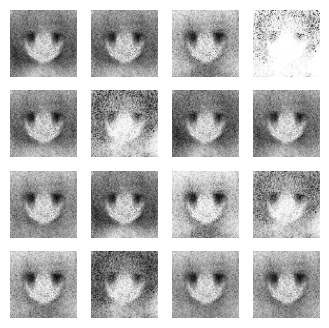

Epoch: 1


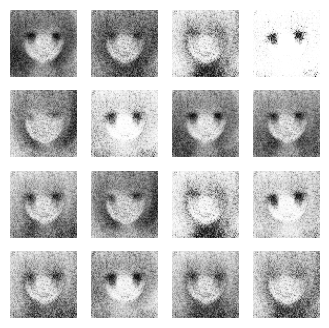

Epoch: 2


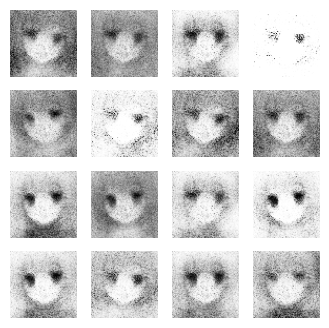

Epoch: 3


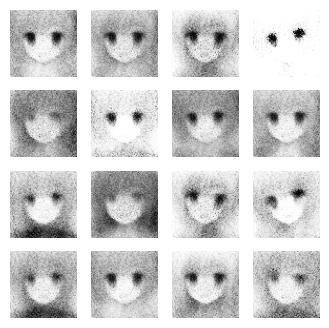

Epoch: 4


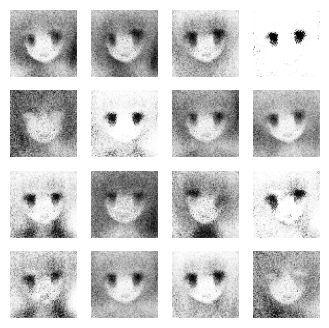

Epoch: 5


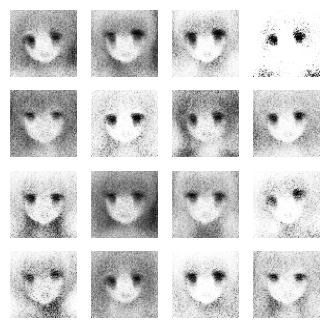

Epoch: 6


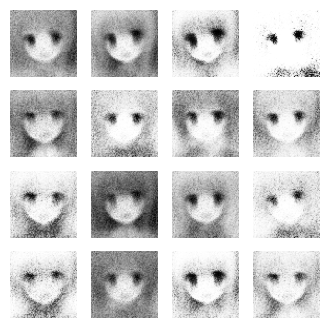

Epoch: 7


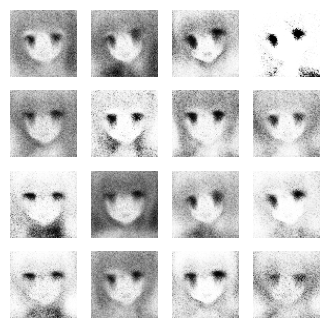

Epoch: 8


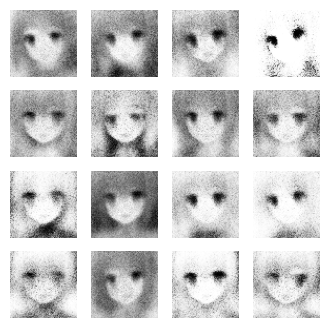

Epoch: 9


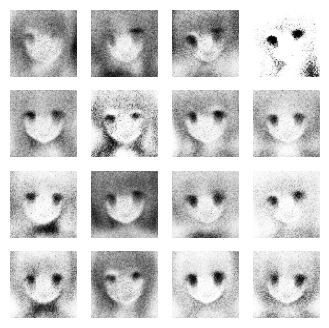

Epoch: 10


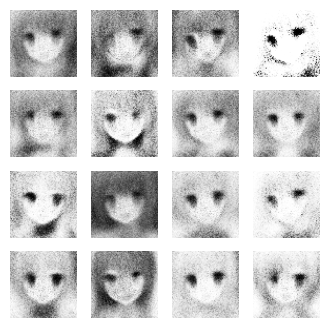

Epoch: 11


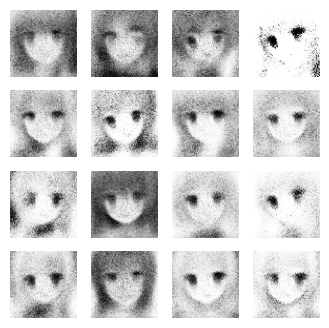

Epoch: 12


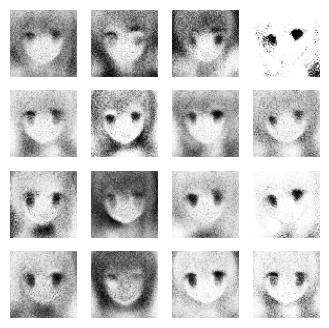

Epoch: 13


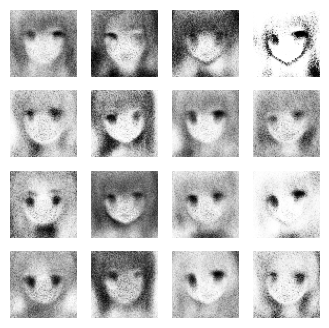

Epoch: 14


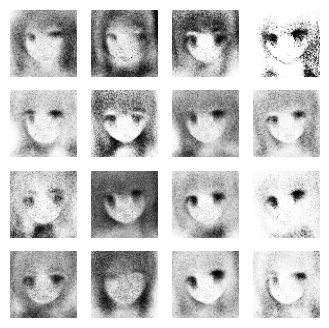

Epoch: 15


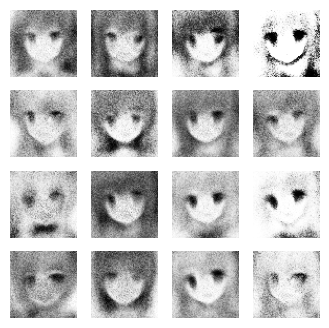

Epoch: 16


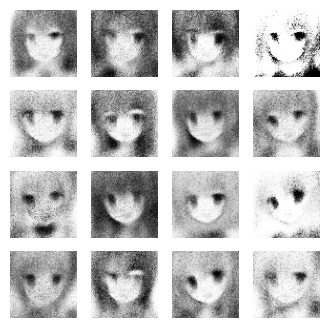

Epoch: 17


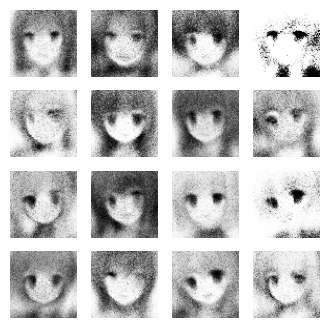

Epoch: 18


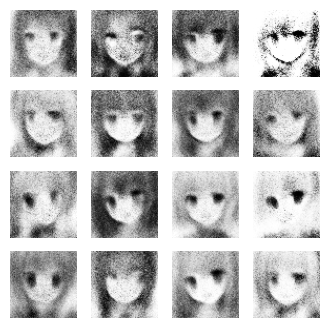

Epoch: 19


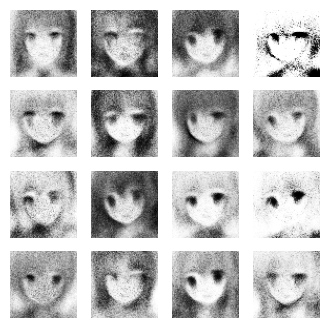

Epoch: 20


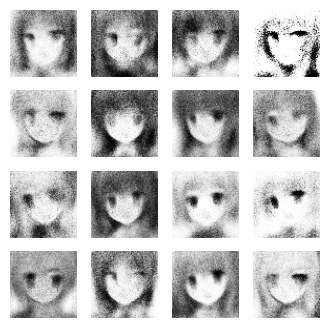

KeyboardInterrupt: 

In [8]:
D_loss = []    # 记录训练过程中判别器的损失变化
G_loss = []    # 记录训练过程中生成器的损失变化
epochs = 100
# 训练环节
for epoch in range(epochs):
    D_epoch_loss = 0    # 用于累加一个epoch中的D的损失
    G_epoch_loss = 0    # 用于累加一个epoch中的G的损失
    count = len(train_dl)  # 共计的batch数量
    for step,(img,_) in enumerate(train_dl):
        size = img.shape[0]  # 获取bath大小
        random_seed = torch.randn(size,100)
        
        #######判别器损失值#######
        # 第一部分 真实图片的判定
        d_optimizer.zero_grad()   # 第 1-1 步 梯度归零 
        real_output = dis(img)    # 第 1-2 步 将原图传入判别器
        d_real_loss = loss_fn(real_output,torch.ones_like(real_output)) # 第1-3 获取损失值（真实图片与真实图片） 
        d_real_loss.backward()    # 第 1-4 步 误差向后传递
        
        # 第二部分 判定生成图片
        generated_img = gen(random_seed)           # 第 2-1 生成器输入随机张量得到生成图片
        fake_output = dis(generated_img.detach())  # 第 2-2 判别器输入生成图像
        d_fake_loss = loss_fn(fake_output,torch.zeros_like(fake_output))
        d_fake_loss.backward()
        
        disc_loss = d_real_loss + d_fake_loss
        d_optimizer.step() 
        #######判别器损失值end#######
        
        #######生成器损失值#######
        g_optimizer.zero_grad()
        fake_output = dis(generated_img)
        gen_loss = loss_fn(fake_output,torch.ones_like(fake_output))
        gen_loss.backward()
        g_optimizer.step()
        #######生成器损失值end#######
        
        # 记录器
        with torch.no_grad():
            D_epoch_loss += disc_loss
            G_epoch_loss += gen_loss
        
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        print('Epoch:',epoch)
        generate_and_save_image(gen,epoch,test_seed)